In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
dataset = pd.read_csv('avocado.csv')
dataset.drop('Unnamed: 0', axis=1, inplace=True)
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset['Month'] = dataset['Date'].apply(lambda x:x.month)
dataset['Day'] = dataset['Date'].apply(lambda x:x.day)
dataset_us = dataset[dataset['region'] == 'TotalUS']
dataset_us.head()

Date  AveragePrice  Total Volume        4046         4225  \
2652 2015-12-27          0.95   27297983.67  9626901.09  10197890.05   
2653 2015-12-20          0.98   25083647.17  8710021.76   9329861.85   
2654 2015-12-13          0.93   28041335.38  9855053.66  10805838.91   
2655 2015-12-06          0.89   28800396.57  9405464.36  12160838.62   
2656 2015-11-29          0.99   22617999.38  8094803.56   9003178.41   

            4770  Total Bags  Small Bags  Large Bags  XLarge Bags  \
2652  1184340.09  6288852.44  4850404.09  1252626.31    185822.04   
2653  1201020.01  5842743.55  4618389.66  1025048.77    199305.12   
2654  1016163.17  6364279.64  4964462.13  1371440.28     28377.23   
2655   931830.63  6302262.96  5005077.36  1233956.21     63229.39   
2656   731008.41  4789009.00  3901953.04   856560.34     30495.62   

              type  year   region  Month  Day  
2652  conventional  2015  TotalUS     12   27  
2653  conventional  2015  TotalUS     12   20  
2654  conventional  2015  TotalUS     12   13  
2655  conventional  2015  TotalUS     12    6  
2656  conventional  2015  TotalUS     11   29

In [3]:
# dataset_array = dataset_us.to_numpy()
# volume = dataset_array[:,2]
# plt.hist(volume)
# plt.xlabel('Total volume')
# plt.title('Total volume')

The correlation matrix:


AveragePrice    1.000000
4046            0.208317
Total Volume    0.192752
4770            0.179446
Total Bags      0.177088
Small Bags      0.174730
Large Bags      0.172940
4225            0.172928
Month           0.162409
XLarge Bags     0.117592
year            0.093197
Day             0.027386
Name: AveragePrice, dtype: float64

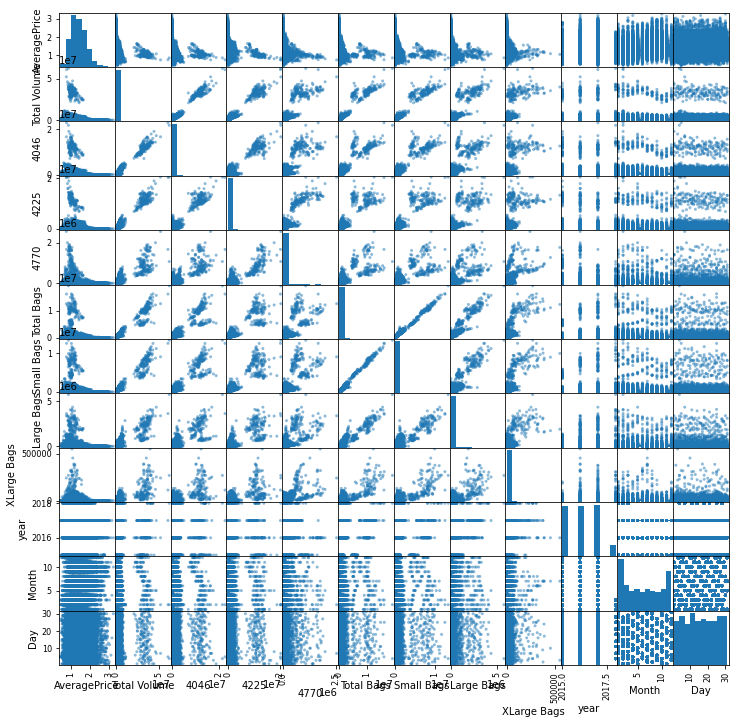

In [18]:
dataset_2bp = pd.get_dummies(dataset_us)
# Scatter plot of the data
from pandas.plotting import scatter_matrix
scatter_matrix(dataset,figsize = (12,12))
print('The correlation matrix:')
corr_mtx = dataset.corr()
corr_mtx.round(2)
corr_mtx['AveragePrice'].abs().sort_values(ascending = False)

In [16]:
from sklearn.linear_model import BayesianRidge
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate # split data randomly into train and test subsets
# from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler # standarization
from sklearn import metrics

In [6]:
# X year-month-day
X=dataset_2bp.iloc[:,[2,10,11,12]]      # 选feature
y=dataset_2bp['AveragePrice']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
print(X)

       Total Volume  year  Month  Day
2652    27297983.67  2015     12   27
2653    25083647.17  2015     12   20
2654    28041335.38  2015     12   13
2655    28800396.57  2015     12    6
2656    22617999.38  2015     11   29
...             ...   ...    ...  ...
18220    1384683.41  2018      2    4
18221    1336979.09  2018      1   28
18222    1283987.65  2018      1   21
18223    1476651.08  2018      1   14
18224    1517332.70  2018      1    7

[338 rows x 4 columns]


In [8]:
lr=LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)

# perform cross-validation
cv_score = cross_val_score(lr, X, y, scoring='neg_root_mean_squared_error', cv=5)
cv_score = np.abs(np.mean(cv_score))

print("Model Report for linear regression")
print('MAE:', metrics.mean_absolute_error(y_test, pred_lr))
print('MSE:', metrics.mean_squared_error(y_test, pred_lr))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, pred_lr)))
print('CV Score:', cv_score)
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % metrics.r2_score(y_test, pred_lr))

X_train.shape, y_train.shape,X_test.shape, y_test.shape, pred_lr.shape

Model Report for linear regression
MAE: 0.11789661772312252
MSE: 0.022170236884050544
RMSE: 0.14889673228130476
CV Score: 0.155576959425884
Coefficient of determination: 0.71


((270, 4), (270,), (68, 4), (68,), (68,))

In [9]:
ebr = BayesianRidge()
ebr.fit(X_train, y_train)
pred_ebr = ebr.predict(X_test)

print("Model Report for Empirical Bayesian regression")
print('MAE:', metrics.mean_absolute_error(y_test, pred_ebr))
print('MSE:', metrics.mean_squared_error(y_test, pred_ebr))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, pred_ebr)))
print('CV Score:', cv_score)
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % metrics.r2_score(y_test, pred_ebr))

Model Report for Empirical Bayesian regression
MAE: 0.1168605359710124
MSE: 0.02193221411586816
RMSE: 0.1480952872844648
CV Score: 0.155576959425884
Coefficient of determination: 0.72


In [12]:
class BayesianRegression():
    """
    Bayesian regression model

    w ~ N(w|0, alpha^(-1)I)
    y = X @ w
    t ~ N(t|X @ w, beta^(-1))
    """

    def __init__(self, alpha:float=1., beta:float=1.):
        self.alpha = alpha
        self.beta = beta
        self.w_mean = None
        self.w_precision = None

    def _is_prior_defined(self) -> bool:
        return self.w_mean is not None and self.w_precision is not None

    def _get_prior(self, ndim:int) -> tuple:
        if self._is_prior_defined():
            return self.w_mean, self.w_precision
        else:
            return np.zeros(ndim), self.alpha * np.eye(ndim)

    def fit(self, X:np.ndarray, t:np.ndarray):
        """
        bayesian update of parameters given training dataset

        Parameters
        ----------
        X : (N, n_features) np.ndarray
            training data independent variable
        t : (N,) np.ndarray
            training data dependent variable
        """

        mean_prev, precision_prev = self._get_prior(np.size(X, 1))

        w_precision = precision_prev + self.beta * X.T @ X
        w_mean = np.linalg.solve(
            w_precision,
            precision_prev @ mean_prev + self.beta * X.T @ t
        )
        self.w_mean = w_mean
        self.w_precision = w_precision
        self.w_cov = np.linalg.inv(self.w_precision)

    def predict(self, X:np.ndarray, return_std:bool=False, sample_size:int=None):
        """
        return mean (and standard deviation) of predictive distribution

        Parameters
        ----------
        X : (N, n_features) np.ndarray
            independent variable
        return_std : bool, optional
            flag to return standard deviation (the default is False)
        sample_size : int, optional
            number of samples to draw from the predictive distribution
            (the default is None, no sampling from the distribution)

        Returns
        -------
        y : (N,) np.ndarray
            mean of the predictive distribution
        y_std : (N,) np.ndarray
            standard deviation of the predictive distribution
        y_sample : (N, sample_size) np.ndarray
            samples from the predictive distribution
        """

        if sample_size is not None:
            w_sample = np.random.multivariate_normal(
                self.w_mean, self.w_cov, size=sample_size
            )
            y_sample = X @ w_sample.T
            return y_sample
        y = X @ self.w_mean
        if return_std:
            y_var = 1 / self.beta + np.sum(X @ self.w_cov * X, axis=1)
            y_std = np.sqrt(y_var)
            return y, y_std
        return y
 
    def _log_likelihood(self, X, t, w):
        return -0.5 * self.beta * np.square(t - X @ w).sum()

In [13]:
br = BayesianRegression(alpha=1, beta=100.)
br.fit(X_train, y_train)
pred_br = br.predict(X_test)

print("Model Report for Empirical Bayesian regression")
print('MAE:', metrics.mean_absolute_error(y_test, pred_br))
print('MSE:', metrics.mean_squared_error(y_test, pred_br))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, pred_br)))
print('CV Score:', cv_score)
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % metrics.r2_score(y_test, pred_br))

Model Report for Empirical Bayesian regression
MAE: 0.1227952526437685
MSE: 0.02514091447146016
RMSE: 0.15855886752704865
CV Score: 0.155576959425884
Coefficient of determination: 0.68
